## Model Evaluation Notebook: Mitochondrial Toxicity Prediction

This notebook provides a comprehensive evaluation of the machine learning model for mitochondrial toxicity prediction trained using Morgan Fingerprints Count featurised data. 

**Notebook Structure**
- Confusion Matrix & Error Analysis
- Classification Metrics (Accuracy, Precision, Recall, F1)
- Threshold Optimization
- SHAP & Feature Interpretation

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    precision_recall_curve,
    auc, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score
)
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import SMOTE
import matplotlib.colors as mcolors

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
colors = sns.color_palette("deep")

# load validation and test data
test_data = pd.read_csv('../../data/MorganCount/tox21_test_featurized.csv').dropna()
valid_data = pd.read_csv('../../data/MorganCount/tox21_valid_featurized.csv')

X_val, y_val = valid_data.filter(regex='^dim_.*'), valid_data['Y']
X_test, y_test = test_data.filter(regex='^dim_.*'), test_data['Y']

model = joblib.load("../../models/Morgan_trained_model.joblib")

# Predictions
y_pred, y_true = model.predict(X_test), y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

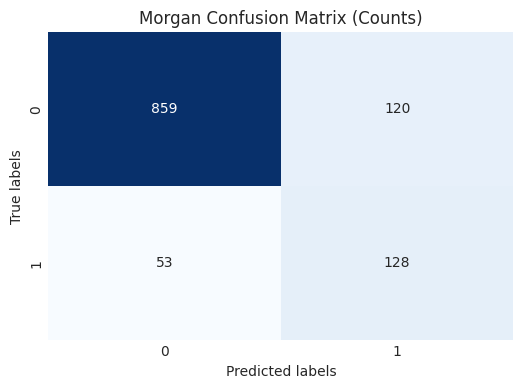

In [11]:
# Compute the confusion matrix from true and predicted labels
cm = confusion_matrix(y_true, y_pred)

# Create a matplotlib figure with specified size
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# Plot the confusion matrix as a heatmap with annotations
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes, cbar=False)

# Set axis labels and title
axes.set_xlabel('Predicted labels')
axes.set_ylabel('True labels')
axes.set_title('Morgan Confusion Matrix (Counts)')


# Save the confusion matrix figure to the figures directory
plt.savefig("../../Figures(evaluation)/confusion_matrix(morgan).png")

# Display the plot
plt.show()


### FIGURE 1. Confusion Matrix

Key observations:

- True Positives (correctly predicted class 1): 128 cases 
- True Negatives (correctly predicted class 0): 859 cases 
- False Positives (class 0 incorrectly predicted as class 1): 120 cases 
- False Negatives (class 1 incorrectly predicted as class 0): 53 cases  


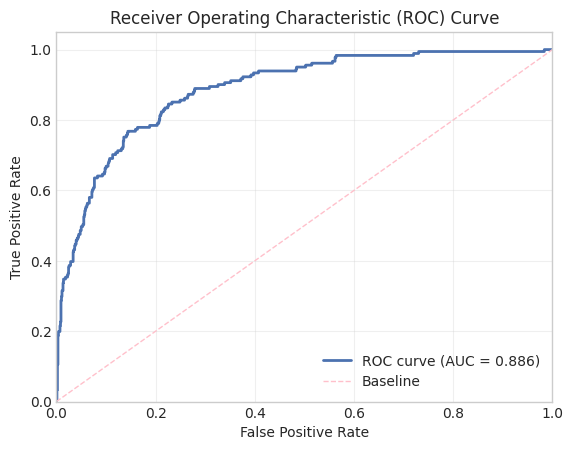

ROC-AUC:0.8859220424494495


In [18]:
#get predicted probabilities
y_score = y_pred_proba

#False Positive Rate (FPR), True Positive Rate (TPR) for various thresholds
fpr, tpr, _ = roc_curve(y_true, y_score)

#calculate the Area Under the ROC Curve (AUROC)
auroc_score = roc_auc_score(y_test, y_pred_proba)

#plot the curve
plt.plot(fpr, tpr, color=colors[0], lw=2, 
        label=f'ROC curve (AUC = {auroc_score:.3f})')
    
# Plot the baseline
plt.plot([0, 1], [0, 1], color='pink', lw=1, linestyle='--', label='Baseline')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("../../Figures(evaluation)/ROC_curve(morgan).png")

#display the plot
plt.show()


print(f"ROC-AUC:{auroc_score}")

### FIGURE 2. ROC curve 

The ROC curve visualizes the trade-off between correctly identifying positive cases (true positive rate) and incorrectly identifying negative cases as positive (false positive rate). 

The model did a pretty good job, with an AUC of 0.886. This means that the model was about 88.6% accurate in figuring out whether a compound belonged to the positive or negative class. 

Because we have a lot more negative cases in our data than positive ones, the ROC curve might make our model seem better than it actually is. Even if the model wrongly classifies some negative cases, the overall rate of those mistakes (the False Positive Rate) will look small because there are just so many true negatives to begin with. Basically if it only correctly predicts true negatives and wrongly predicts all true positives, it's ROC-AUC might still be high. 

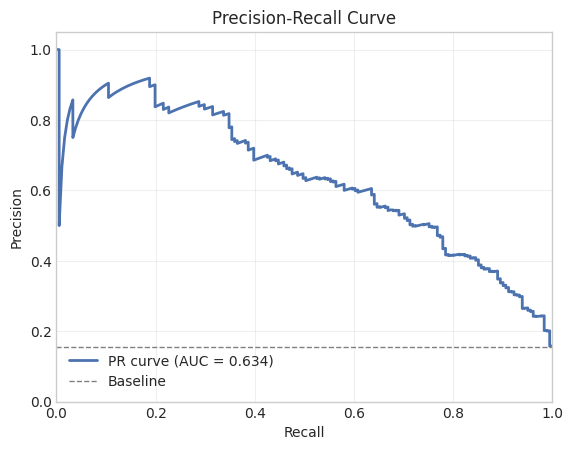

In [15]:
#Get predicted probabilities for the positive class (class 1)
y_score = y_pred_proba

#Compute precision-recall pairs for different thresholds
precision, recall, _ = precision_recall_curve(y_true, y_score)

#Calculate area under the precision-recall curve (PR AUC)
pr_auc = auc(recall, precision)

#plot the pr curve     
plt.plot(recall, precision, color=colors[0], lw=2,
        label=f'PR curve (AUC = {pr_auc:.3f})')

#calculates the proportion of positive samples (class 1) in the dataset.
no_skill = len(y_true[y_true == 1]) / len(y_true)

#plots a horizontal dashed line across the precision-recall plot to show baseline
plt.plot([0, 1], [no_skill, no_skill], color='gray', lw=1, linestyle='--', label='Baseline')

#Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

#Save the plot to the figures directory
plt.savefig("../../Figures(evaluation)/PR_curve(morgan).png")
plt.show()


### FIGURE 3. Precision-Recall Curve

A Precision-Recall (PR) curve is a graph that illustrates the trade-off between precision and recall for a given model, visualizing how these metrics change as a classification threshold varies.

The Area Under the precision-recall Curve (AUC-PR) is 0.634, which suggests that the model performs moderately for the minority class. For context, AUC-PR > 0.7: Strong, AUC-PR = 0.5: Random guessing, AUC-PR < 0.5: Worse than random.

For imbalanced data, high recall often means lower precision and vice versa. From the confusion matrix, we can see that the model has a good recall of true negatives, but it struggles more at identifying true positives (low precision). 



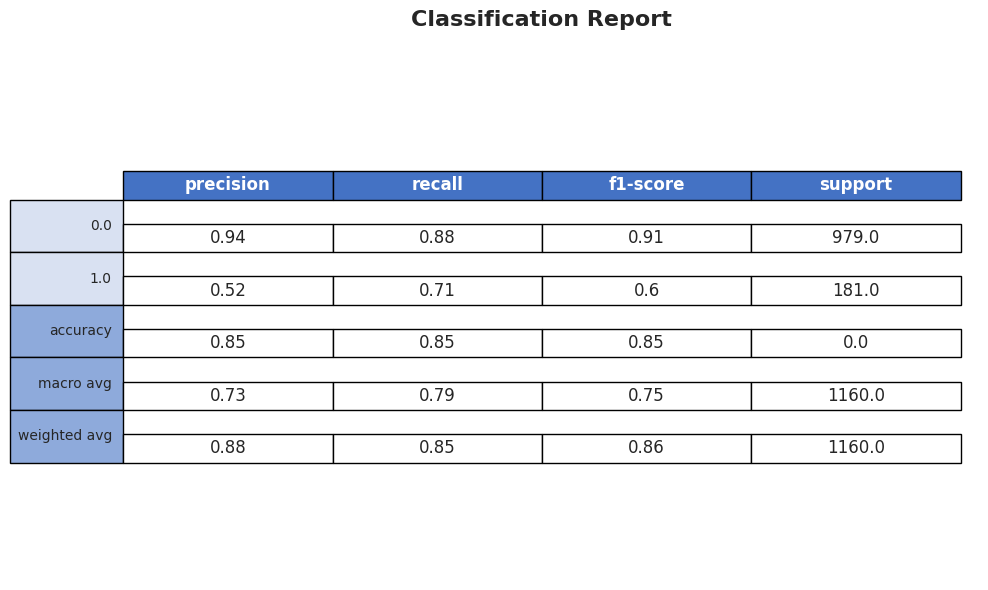

In [ ]:
# Get the classification report as a dictionary
report = classification_report(y_true, y_pred, output_dict=True)
    
# Convert to DataFrame for easier handling
df = pd.DataFrame(report).T
    
# Drop the support as a percentage column if it exists
if 'support' in df.columns:
    # Convert support to integer
    df['support'] = df['support'].astype(int)
    
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
    
# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
    
# Create the table
table = ax.table(
    cellText=np.round(df.values, 2).astype(str),
    rowLabels=df.index,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.2] * len(df.columns)
)
    
# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
    
# Color header row
header_cells = [table[0, i] for i in range(len(df.columns))]
for cell in header_cells:
    cell.set_facecolor('#4472C4')
    cell.set_text_props(color='white', fontweight='bold')
    
# Color index column
for i in range(len(df)):
    cell = table[i+1, -1]  # Last column cells
    if df.index[i] in ['accuracy', 'macro avg', 'weighted avg']:
        cell.set_facecolor('#8EAADB')
    
# Color row labels (first column)
for i in range(len(df)):
    cell = table[i+1, -1]
    if df.index[i] in ['accuracy', 'macro avg', 'weighted avg']:
        table.add_cell(i+1, -1, width=0.3, height=0.1,
                    text=df.index[i], loc='right',
                    facecolor='#8EAADB')
    else:
        table.add_cell(i+1, -1, width=0.3, height=0.1,
                    text=df.index[i], loc='right',
                    facecolor='#D9E1F2')
    
# Add title
plt.title('Classification Report', fontsize=16, fontweight='bold', pad=20)
plt.savefig("../../Figures(evaluation)/classification_report(morgan).png")
plt.tight_layout()



### FIGURE 4. Classsification report table. 
Contains a summary of Accuracy, Precision, Recall and F1 scores.

Optimal Threshold: 0.444


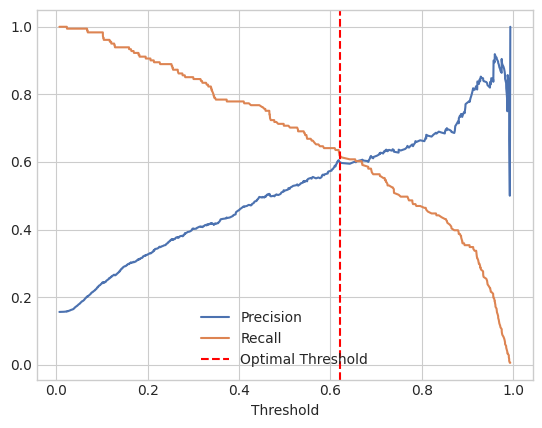

In [ ]:
#Threshold Optimiation

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
optimal_idx = np.argmax(precision + recall)  # Or customize (e.g., F2-score)
print(f"Optimal Threshold: {thresholds[optimal_idx]:.3f}") 

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=0.62, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.legend()
plt.savefig("../../Figures(evaluation)/optimal_threshold(morgan).png")
plt.show()


### FIGURE 5. Precision-Recall (PR) vs. Threshold plot

This Precision-Recall (PR) vs. Threshold plot highlights critical trade-offs in the model's performance. The precision curve (blue) shows that at high thresholds (e.g., >0.8), the model predicts toxicity only when highly confident, minimizing false positives. However, this comes at the cost of low recall, many truly toxic compounds are missed, which is risky for safety. As the threshold lowers, recall improves (more toxic compounds detected), but precision drops sharply due to increased false alarms (safe compounds mislabeled as toxic).

The optimal threshold (0.44) balances these metrics, but the choice depends on the use case: High recall is often prioritized in toxicity screening to avoid harmful false negatives.

/home/muobo/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


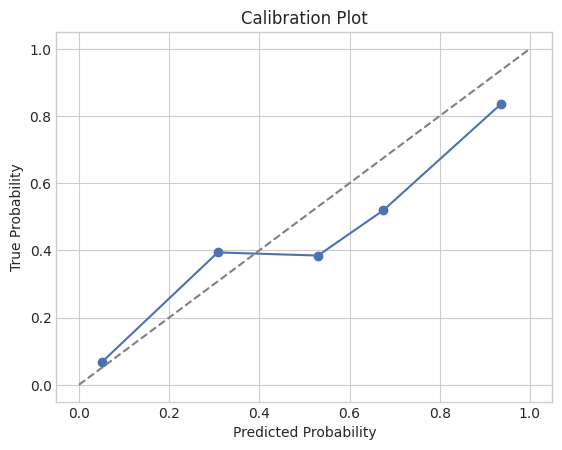

In [8]:
from sklearn.calibration import CalibratedClassifierCV
import numpy as np


# Using CalibratedClassifierCV with 'sigmoid' method (Platt scaling)
calibrated_model = CalibratedClassifierCV(
    estimator=model,
    method='isotonic',
    cv='prefit'  
)
# Fit the calibrator
calibrated_model.fit(X_val, y_val)

#Calibration
y_proba = calibrated_model.predict_proba(X_test)[:, 1]
y_True = y_test
y = calibrated_model.predict(X_test)


from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_True, y_proba, n_bins=5)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.savefig('../../Figures(evaluation)/calibration_plot(Morgan).png')


### FIGURE 6. Calibration plot

The visual shows that from probabilities 0.0 to about 0.4, the model is very well calibrated, with points falling almost exactly on the ideal diagonal line. For probabilities above 0.5, the blue line falls slightly below the diagonal, indicating the model is somewhat underconfident in this range, it's predicting probabilities that are slightly higher than the actual observed frequencies. The model's high-confidence predictions (>0.8) might be slightly overestimated.

### SUMMARY

**Key Performance Metrics**

- Accuracy: 85% – High overall correctness, but might be exxagerated due to the class imbalance.
- Precision: 52% – When predicting toxicity, ~48% of flagged compounds may be false alarms.
- Recall: 71% – Captures ~71% of truly toxic compounds, critical for safety screening.
- F1-score: 0.60 – Balances precision and recall, indicating imperfect performance.

**Interpretability & Limitations**

- Threshold optimization suggested a decision cutoff of ~0.44 to balance precision and recall, though domain-specific adjustments may be needed (e.g., lower thresholds for higher recall in preclinical safety).

**Final Assessment and Recommendations**

The model performs well, with an ROC-AUC (0.89) matching many published Tox21 challenge models, though its PR-AUC (0.63) shows room for improvement. While the current results are promising, it can be even better by:

- Adding more chemical knowledge to reduce mistakes
- Adjusting for specific drug discovery needs 